# Forest Fire Prediction

## Imports

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import shap

## Dataset

In [4]:
df = pd.read_csv('forest_fire_dataset.csv')
df['Date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.drop(columns=['day', 'month', 'year', 'Classes', 'Region'], inplace=True)
df.set_index('Date', inplace=True)

df.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
Date,,,,,,,,,,
2012-06-01,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5
2012-06-02,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4
2012-06-03,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1
2012-06-04,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0
2012-06-05,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5


In [5]:
df.shape

(243, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 243 entries, 2012-06-01 to 2012-09-30
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  243 non-null    int64  
 1   RH           243 non-null    int64  
 2   Ws           243 non-null    int64  
 3   Rain         243 non-null    float64
 4   FFMC         243 non-null    float64
 5   DMC          243 non-null    float64
 6   DC           243 non-null    float64
 7   ISI          243 non-null    float64
 8   BUI          243 non-null    float64
 9   FWI          243 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 20.9 KB


In [7]:
df.isnull().sum()

Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
dtype: int64

In [8]:
summary = df.describe().transpose().round(2)
summary

,count,mean,std,min,25%,50%,75%,max
Temperature,243.0,32.15,3.63,22.0,30.00,32.0,35.00,42.0
RH,243.0,62.04,14.83,21.0,52.50,63.0,73.50,90.0
Ws,243.0,15.49,2.81,6.0,14.00,15.0,17.00,29.0
Rain,243.0,0.76,2.00,0.0,0.00,0.0,0.50,16.8
FFMC,243.0,77.84,14.35,28.6,71.85,83.3,88.30,96.0
DMC,243.0,14.68,12.39,0.7,5.80,11.3,20.80,65.9
DC,243.0,49.43,47.67,6.9,12.35,33.1,69.10,220.4
ISI,243.0,4.74,4.15,0.0,1.40,3.5,7.25,19.0
BUI,243.0,16.69,14.23,1.1,6.00,12.4,22.65,68.0
FWI,243.0,7.04,7.44,0.0,0.70,4.2,11.45,31.1


## Linear Regression Model

In [9]:
X = df.drop('FWI', axis=1)
y = df['FWI']

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.20, random_state=42)

X_train.shape, X_test.shape

((194, 9), (49, 9))

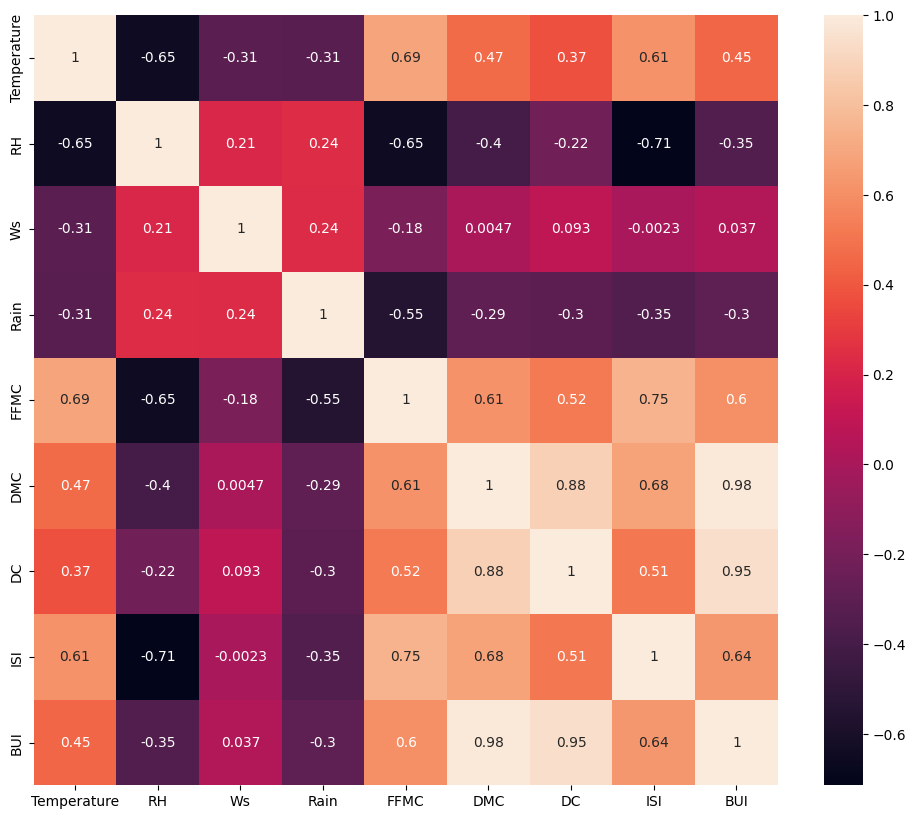

In [10]:
plt.figure(figsize=(12,10))
sns.heatmap(X_train.corr(), annot=True)
plt.show()

# TODO: Multikolinearität, Feature Scaling

In [11]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [12]:
corr_features = correlation(X_train, 0.85)
corr_features

{'BUI', 'DC'}

In [13]:
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

In [163]:
#scaler=StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [14]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
train_score = linreg.score(X_train, y_train)
test_score = r2_score(y_test, y_pred)

print("Mean absolute error: ", mae)
print("Mean squared error:  ", mse)
print("Train R2 score:      ", train_score)
print("Test R2 Score:       ", test_score)


Mean absolute error:  0.5373724919046496
Mean squared error:   0.7875651833867783
Train R2 score:       0.9688199614465702
Test R2 Score:        0.9740149719239102


In [15]:
cdf = pd.DataFrame(linreg.coef_.round(5), X_train.columns, columns=['Coefficients'])
cdf.loc['Intercept'] = linreg.intercept_.round(5)
cdf

,Coefficients
Temperature,0.00087
RH,0.00627
Ws,0.01252
Rain,-0.01528
FFMC,-0.04072
DMC,0.29096
ISI,1.17136
Intercept,-0.21235


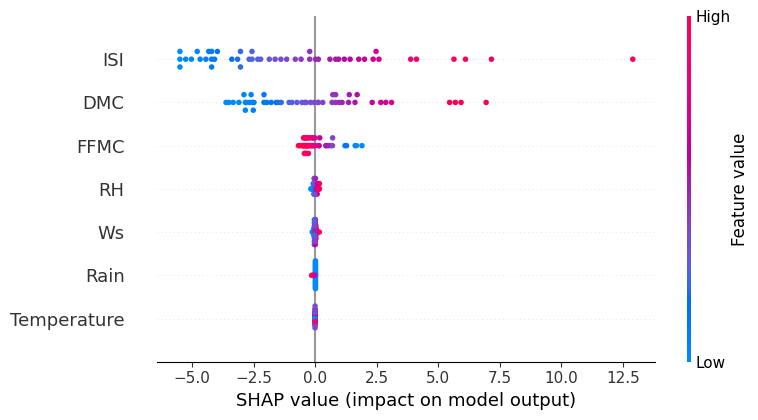

In [16]:
explainer = shap.Explainer(linreg, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

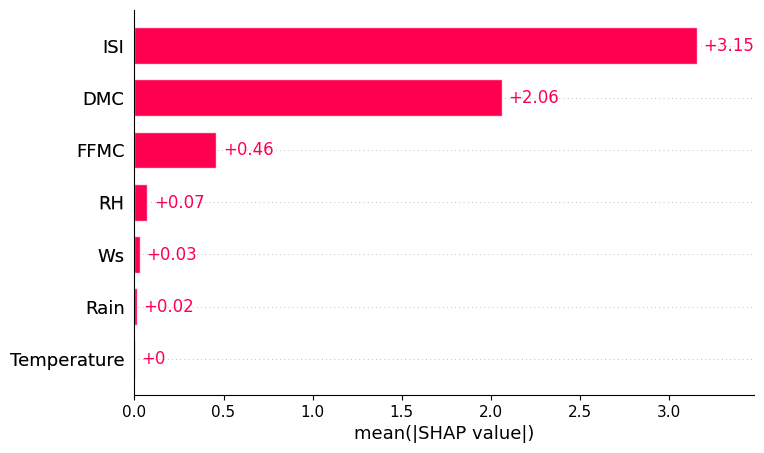

In [17]:
shap.plots.bar(shap_values)

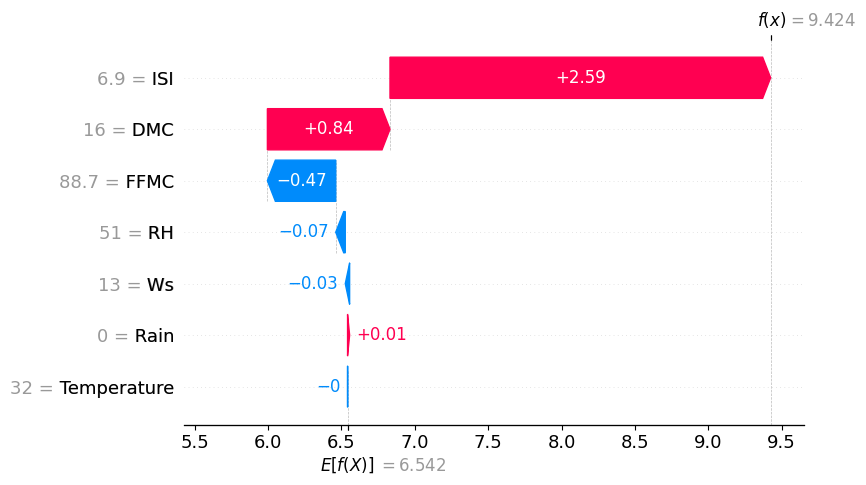

In [18]:
sample_ind = 12
shap.plots.waterfall(shap_values[sample_ind])

In [169]:
shap.plots.force(shap_values[sample_ind])

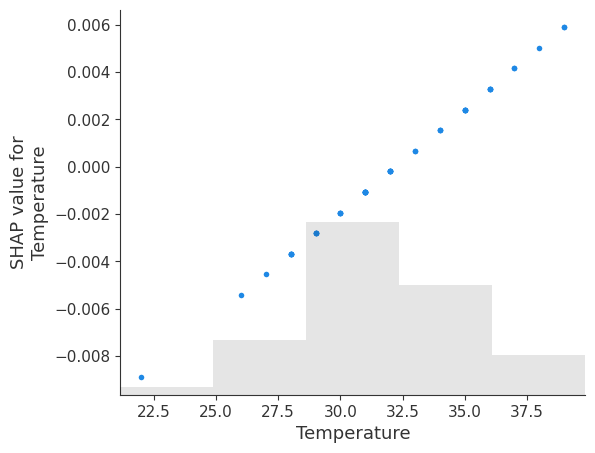

In [19]:
shap.plots.scatter(shap_values[:, "Temperature"])

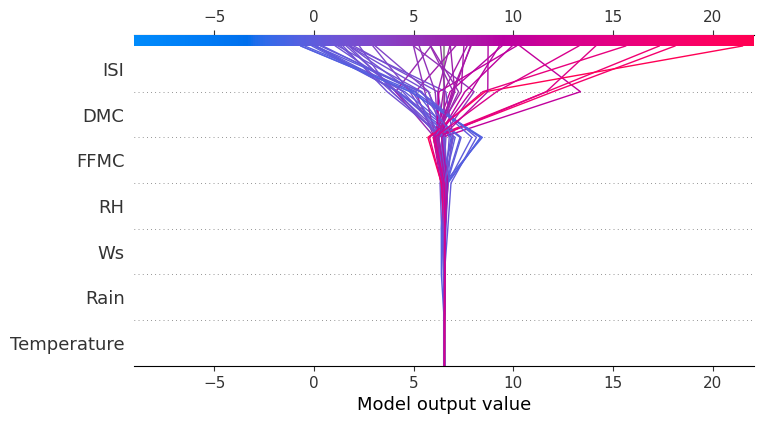

In [20]:
shap.decision_plot(explainer.expected_value, shap_values.values, X_test)
